<a href="https://colab.research.google.com/github/YoheiFukuhara/recommender-system/blob/main/10_mf_keras_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/Recommend/output/'
df = pd.read_csv(BASE_PATH+'edited_rating.csv')
pd.options.display.float_format = '{:.2f}'.format
df.info()
display(df.describe())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   movie_idx  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


,userId,movieId,rating,movie_idx
count,20000263.00,20000263.00,20000263.00,20000263.00
mean,69044.87,9041.57,3.53,3612.60
std,40038.63,19789.48,1.05,4154.44
min,0.00,1.00,0.50,0.00
25%,34394.00,902.00,3.00,887.00
50%,69140.00,2167.00,3.50,2085.00
75%,103636.00,4770.00,4.00,4677.00
max,138492.00,131262.00,5.00,26743.00


,userId,movieId,rating,movie_idx
0,0,2,3.50,2
1,0,29,3.50,29
2,0,32,3.50,32
3,0,47,3.50,47
4,0,50,3.50,50
...,...,...,...,...
20000258,138492,68954,4.50,13821
20000259,138492,69526,4.50,13929
20000260,138492,69644,3.00,13942
20000261,138492,70286,5.00,14060


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   movie_idx  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


,userId,movieId,rating,movie_idx
count,20000263.00,20000263.00,20000263.00,20000263.00
mean,69044.87,9041.57,3.53,3612.60
std,40038.63,19789.48,1.05,4154.44
min,0.00,1.00,0.50,0.00
25%,34394.00,902.00,3.00,887.00
50%,69140.00,2167.00,3.50,2085.00
75%,103636.00,4770.00,4.00,4677.00
max,138492.00,131262.00,5.00,26743.00


,userId,movieId,rating,movie_idx
0,0,2,3.50,2
1,0,29,3.50,29
2,0,32,3.50,32
3,0,47,3.50,47
4,0,50,3.50,50
...,...,...,...,...
20000258,138492,68954,4.50,13821
20000259,138492,69526,4.50,13929
20000260,138492,69644,3.00,13942
20000261,138492,70286,5.00,14060


In [11]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

In [12]:
# split into train and test
df = df.sample(frac=0.1, random_state=42)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0)

In [13]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        1384930     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        267440      ['input_2[0][0]']                
                                                                                              

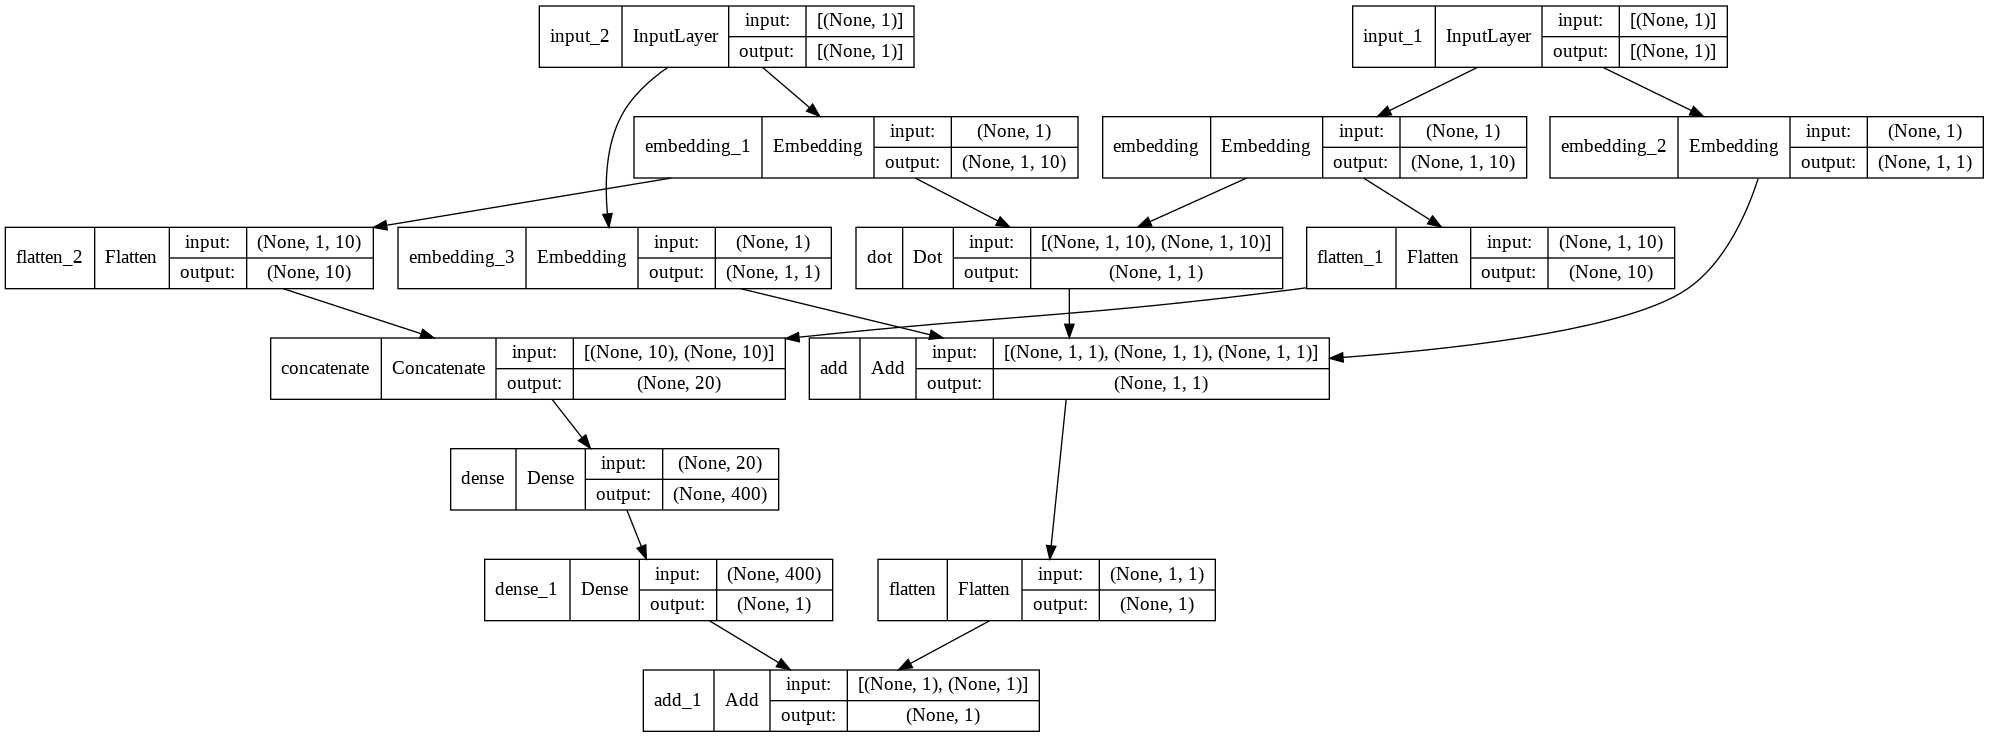

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 10)        1384930     ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 10)        267440      ['input_4[0][0]']                
                                                                                            

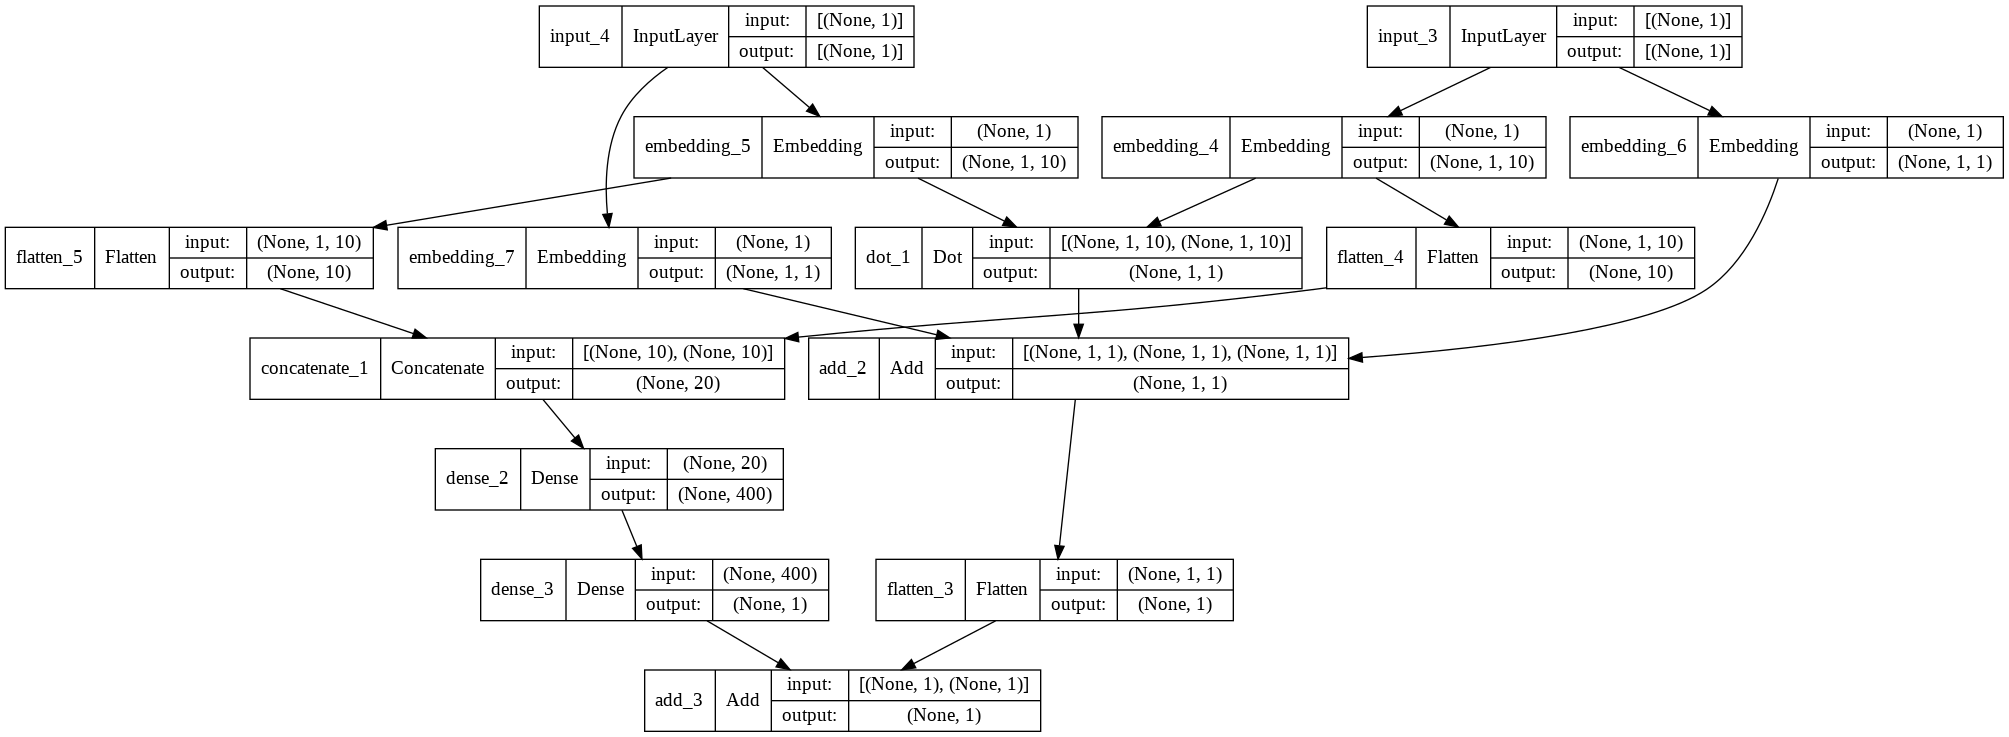

In [14]:
u = tf.keras.layers.Input(shape=(1,))
m = tf.keras.layers.Input(shape=(1,))
u_embedding = tf.keras.layers.Embedding(N, K)(u) # (N, 1, K)
m_embedding = tf.keras.layers.Embedding(M, K)(m) # (N, 1, K)

u_bias = tf.keras.layers.Embedding(N, 1)(u) # (N, 1, 1)
m_bias = tf.keras.layers.Embedding(M, 1)(m) # (N, 1, 1)

x = tf.keras.layers.Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = tf.keras.layers.Add()([x, u_bias, m_bias])
x = tf.keras.layers.Flatten()(x) # (N, 1)

u_embedding = tf.keras.layers.Flatten()(u_embedding) # (N, K)
m_embedding = tf.keras.layers.Flatten()(m_embedding) # (M, K)
y = tf.keras.layers.Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = tf.keras.layers.Dense(400, activation='elu')(y)
y = tf.keras.layers.Dense(1)(y)

x = tf.keras.layers.Add()([x, y])

model = tf.keras.models.Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.08, momentum=0.9),
  metrics=['mse'],
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
%%time
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  ),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/15
12501/12501 [==============================] - 74s 6ms/step - loss: 0.8787 - mse: 0.8787 - val_loss: 0.8302 - val_mse: 0.8302
Epoch 2/15
12501/12501 [==============================] - 75s 6ms/step - loss: 0.7735 - mse: 0.7735 - val_loss: 0.7849 - val_mse: 0.7849
Epoch 3/15
12501/12501 [==============================] - 71s 6ms/step - loss: 0.7263 - mse: 0.7263 - val_loss: 0.7885 - val_mse: 0.7885
Epoch 4/15
12501/12501 [==============================] - 72s 6ms/step - loss: 0.6923 - mse: 0.6923 - val_loss: 0.7858 - val_mse: 0.7858
CPU times: user 5min 44s, sys: 56.5 s, total: 6min 41s
Wall time: 4min 51s
Epoch 1/15
12501/12501 [==============================] - 77s 6ms/step - loss: 0.8756 - mse: 0.8756 - val_loss: 0.8133 - val_mse: 0.8133
Epoch 2/15
12501/12501 [==============================] - 72s 6ms/step - loss: 0.7706 - mse: 0.7706 - val_loss: 0.8544 - val_mse: 0.8544
Epoch 3/15
12501/12501 [==============================] - 76s 6ms/step - loss: 0.7248 - mse: 0.7248 - v

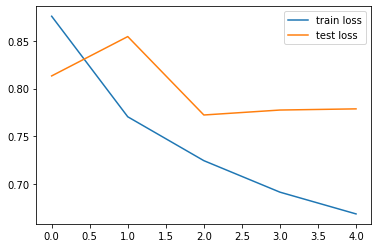

In [18]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

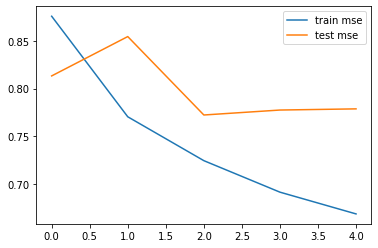

In [19]:
# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()